<a href="https://colab.research.google.com/github/owshah/desktop-tutorial/blob/main/Quantum_Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qiskit[visualization]


In [ ]:
pip install utils


In [ ]:
pip install qiskit-aer


In [ ]:
pip install python-resize-image


#FRQI

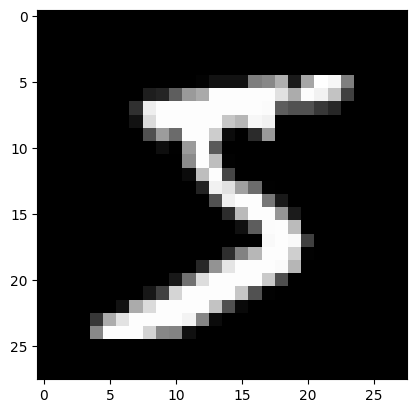

{'001001100101': 3, '011100111101': 5, '100101011100': 13, '011101001000': 16, '001110110000': 12, '100101101000': 10, '010010000101': 3, '010101101101': 2, '010000011100': 14, '001110101000': 17, '010100000000': 11, '011001100000': 18, '010010010000': 10, '101010101101': 2, '100110111001': 7, '101000101100': 17, '101010011100': 15, '100011101001': 8, '100000101000': 14, '001011000001': 8, '010000110001': 33, '001110101100': 21, '001101010100': 36, '100111001100': 13, '010111100001': 12, '001100111000': 16, '001101001100': 12, '100111000100': 13, '011111000001': 54, '011001011100': 24, '100000100100': 13, '010101110100': 20, '001011011100': 12, '001011110000': 12, '001101001000': 15, '001100110100': 14, '010111101000': 209, '100101100100': 15, '010000010001': 108, '101000110100': 16, '001110100000': 271, '010000100000': 10, '100100000000': 13, '100000101100': 328, '011100000100': 1023, '111011001100': 972, '010101011000': 960, '110110101000': 958, '010101010000': 995, '100101101100': 3

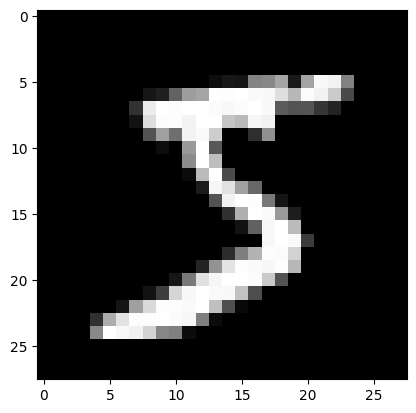

In [ ]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import execute, Aer, BasicAer
import numpy as np
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mutual_info_score, r2_score

def margolus(circ, t, c0, c1):
        circ.ry(np.pi/4,t)
        circ.cx(c0, t)
        circ.ry(np.pi/4,t)
        circ.cx(c1, t)
        circ.ry(-np.pi/4,t)
        circ.cx(c0, t)
        circ.ry(-np.pi/4,t)

def rccx(circ, t, c0, c1):
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)

def rcccx(circ, t, c0, c1, c2):
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c2, t)
        circ.tdg(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c2, t)
        circ.tdg(t)
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)


def ccry(circ, angle, t, c0, c1):
        circ.cu3(angle/2, 0, 0, c1, t)
        circ.cx(c1, c0)
        circ.cu3(-angle/2, 0, 0, c0, t)
        circ.cx(c1, c0)
        circ.cu3(angle/2, 0, 0, c0, t)

def mary(circ, angle, t, c0, c1):
        circ.ry(angle/4,t)
        circ.cx(c0, t)
        circ.ry(-angle/4,t)
        circ.cx(c1, t)
        circ.ry(angle/4,t)
        circ.cx(c0, t)
        circ.ry(-angle/4,t)
        circ.cx(c1, t)

def cccry(circ, angle, t, a, c0, c1, c2):
        margolus(circ, a, c1, c2)
        mary(circ, angle, t, a, c0)
        margolus(circ, a, c1, c2)

def mary_4(circ, angle, t, c0, c1, c2):
        circ.h(t)
        circ.t(t)
        circ.cx(c0,t)
        circ.tdg(t)
        circ.h(t)
        circ.cx(c1,t)
        circ.rz(angle/4,t)
        circ.cx(c2,t)
        circ.rz(-angle/4,t)
        circ.cx(c1,t)
        circ.rz(angle/4,t)
        circ.cx(c2,t)
        circ.rz(-angle/4,t)
        circ.h(t)
        circ.t(t)
        circ.cx(c0,t)
        circ.tdg(t)
        circ.h(t)

def mary_8(circ, angle, t, c0, c1, c2, c3, c4, c5, c6):
        circ.h(t)
        circ.t(t)
        rccx(circ, t, c0, c1)
        circ.tdg(t)
        circ.h(t)
        rccx(circ, t, c2, c3)
        circ.rz(angle/4,t)
        rcccx(circ, t, c4, c5, c6)
        circ.rz(-angle/4,t)
        rccx(circ, t, c2, c3)
        circ.rz(angle/4,t)
        rcccx(circ, t, c4, c5, c6)
        circ.rz(-angle/4,t)
        circ.h(t)
        circ.t(t)
        rccx(circ, t, c0, c1)
        circ.tdg(t)
        circ.h(t)

def c10ry(circ, angle, bin, target, anc, controls):

        clist = []

        for i in bin:
                clist.append(int(i))

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

        margolus(circ, anc, controls[0], controls[1])
        circ.x(controls[0])
        circ.x(controls[1])
        margolus(circ, controls[1], controls[2], controls[3])
        circ.x(controls[2])
        circ.x(controls[3])
        margolus(circ, controls[3], controls[4], controls[5])
        circ.x(controls[4])
        circ.x(controls[5])

        margolus(circ, controls[5], controls[8], controls[9])
        margolus(circ, controls[4], controls[6], controls[7])
        margolus(circ, controls[2], controls[4], controls[5])
        margolus(circ, controls[0], controls[2], controls[3])

        mary_4(circ, angle, target, anc, controls[0], controls[1])

        margolus(circ, controls[0], controls[2], controls[3])
        margolus(circ, controls[2], controls[4], controls[5])
        margolus(circ, controls[4], controls[6], controls[7])
        margolus(circ, controls[5], controls[8], controls[9])

        circ.x(controls[5])
        circ.x(controls[4])
        margolus(circ, controls[3], controls[4], controls[5])
        circ.x(controls[3])
        circ.x(controls[2])
        margolus(circ, controls[1], controls[2], controls[3])
        circ.x(controls[1])
        circ.x(controls[0])
        margolus(circ, anc, controls[0], controls[1])

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

def c10mary(circ, angle, bin, target, anc, controls):
        clist = []

        for i in bin:
                clist.append(int(i))

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

        rccx(circ, anc, controls[4], controls[5])
        circ.x(controls[4])
        circ.x(controls[5])
        rccx(circ, controls[4], controls[6], controls[7])
        rccx(circ, controls[5], controls[8], controls[9])


        mary_8(circ, angle, target, anc, controls[0], controls[1], controls[2], controls[3], controls[4], controls[5])

        rccx(circ, controls[5], controls[8], controls[9])
        rccx(circ, controls[4], controls[6], controls[7])
        circ.x(controls[5])
        circ.x(controls[4])
        rccx(circ, anc, controls[4], controls[5])

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])


if __name__ == '__main__':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        img_num = 0

        #show original image
        plt.imshow(x_train[img_num], cmap='gray')
        #plt.savefig('mnistimg'+str(img_num)+'.png')
        plt.show()

        # 2-dimentional data convert to 1-dimentional array
        x_train = x_train.reshape(60000, 784)
        # change type
        x_train = x_train.astype('float64')
        # Normalization(0~pi/2)
        x_train /= 255.0
        x_train = np.arcsin(x_train)

        backends = Aer.backends()
        #print("Aer backends:",backends)

        qubit = 12
        qc = QuantumCircuit(qubit,qubit)


        # apply hadamard gates
        qc.h(range(2,qubit))

        # apply c10Ry gates (representing color data)
        for i in range(len(x_train[img_num])):
                if x_train[img_num][i] != 0:
                        c10mary(qc, 2 * x_train[img_num][i], format(i, '010b'), 0, 1, [i for i in range(2,12)])


        qc.measure(range(qubit),range(qubit))

        backend_sim = Aer.get_backend('qasm_simulator')
        #print(qc.depth())
        numOfShots = 1024000
        result = execute(qc, backend_sim, shots=numOfShots).result()
        #circuit_drawer(qc).show()
        #plot_histogram(result.get_counts(qc))

        print(result.get_counts(qc))

        # generated image
        genimg = np.array([])

        #### decode
        for i in range(len(x_train[img_num])):
                try:
                        genimg = np.append(genimg,[np.sqrt(result.get_counts(qc)[format(i, '010b')+'01']/numOfShots)])
                except KeyError:
                        genimg = np.append(genimg,[0.0])

        # inverse nomalization
        genimg *= 32.0 * 255.0
        x_train = np.sin(x_train)
        x_train *= 255.0

        # convert type
        genimg = genimg.astype('int')

        # back to 2-dimentional data
        genimg = genimg.reshape((28,28))

        plt.imshow(genimg, cmap='gray', vmin=0, vmax=255)
        plt.savefig('gen_'+str(img_num)+'.png')
        plt.show()

In [ ]:
pip install qiskit


In [ ]:
pip install --upgrade qiskit


#Quantun Edge Detection

In [ ]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute
#from qiskit.aqua.circuits.fourier_transform_circuits import FourierTransformCircuits
from math import pi
from qiskit import Aer

def quantum_adder(circuit, epsilon):
    qubits = circuit.qubits
    n_qubits = circuit.n_qubits
    FourierTransformCircuits.construct_circuit(circuit, qubits)
    for i in range(n_qubits):
        circuit.u1(float(2 * pi * epsilon)/2**(i + 1), qubits[n_qubits - i - 1])
    FourierTransformCircuits.construct_circuit(circuit, qubits, inverse=True)

def quantum_rotate_image(circuit):        #gives you the quantum state where you have to measure the ancilla and obtain 0
    for i in circuit.qubits:
        circuit.x(i)

def quantum_edge_detection(circuit):        #gives you the quantum state where you have to measure the ancilla and obtain 0
    qubits = circuit.qubits
    ancilla = qubits[0]
    circuit.h(ancilla)
    quantum_adder(circuit, -1)
    circuit.h(ancilla)
    circuit.x(ancilla)


# circuit.measure(ancilla, clbit)

# backend = Aer.get_backend('qasm_simulator')
# job_sim = execute(circuit, backend)
# sim_result = job_sim.result()

# print(sim_result.get_counts(circuit))

In [ ]:
pip install qiskit-ibmq-provider


#Create IBM account and copy Token , Manual is in https://docs.quantum-computing.ibm.com/start/setup-channel



In [ ]:
import utils
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit import execute, Aer, BasicAer
from qiskit.providers.aer.noise import NoiseModel
import numpy as np
import matplotlib.pyplot as plt
from resizeimage import resizeimage
from PIL import Image, ImageOps

# import quantum_edge_detection as qed



# Insert API key generated after registring in IBM Quantum Experience
# IBMQ.save_account('API KEY')

IBMQ.load_account()
provider = IBMQ.get_provider( group='open', project='main')


# dimensions of the image
size=32

#target image
image=utils.get_Cat_image()

#normalized image
normalized_image=utils.image_normalization(image,32,True)

#get target image pixel values for comparison with output image
img_arr=utils.get_image_pixel_value(image,32)


# initialize qubits and classical registers for building the circuit
anc = QuantumRegister(1, "anc")
img = QuantumRegister(11, "img")
anc2 = QuantumRegister(1, "anc2")
c = ClassicalRegister(12)

# create circuit
qc = QuantumCircuit(anc, img, anc2, c)

# apply hadamard gates
for i in range(1, len(img)):
    qc.h(img[i])

# frqi circuit from https://github.com/Shedka/citiesatnight
for i in range(len(normalized_image)):
        if normalized_image[i] != 0:
                frqi.c10mary(qc, 2 * normalized_image[i], format(i, '010b'), img[0], anc2[0], [img[j] for j in range(1,len(img))])

#rotate the image 180 deg
# qed.quantum_rotate_image(qc)

#Edge Detection
# qed.quantum_edge_detection()

qc.measure(img, c[1:12])
print(qc.depth())
numOfShots = 1000000


#To add noise on the simulation UNCOMMENT BELOW LINES

# backend = provider.get_backend('ibmq_16_melbourne')
# noise_model = NoiseModel.from_backend(backend)
# # Get coupling map from backend
# coupling_map = backend.configuration().coupling_map
# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

# To run without noise UNCOMMENT BELOW LINES
# result = execute(qc, Aer.get_backend('qasm_simulator'), shots=numOfShots,coupling_map=coupling_map,
#                  basis_gates=basis_gates,
#                  noise_model=noise_model).result()

# To run without noise UNCOMMENT BELOW LINES
result = execute(qc, Aer.get_backend('qasm_simulator'), shots=numOfShots).result()

# Image retrieval from quantum state to pixels

genimg = np.array([])

#### decode
for i in range(len(normalized_image)):
        try:
                genimg = np.append(genimg,[np.sqrt(result.get_counts(qc)[format(i, '010b')+'10']/numOfShots)])
        except KeyError:
                genimg = np.append(genimg,[0.0])



# inverse nomalization
genimg *= size * 255.0
# genimg = np.sin(genimg)

same,notSame= utils.get_count_of_pixel(img_arr,genimg)
print(same,notSame)
percentage= (same/1024)*100
print ("Total image recovered "+ str(percentage))

# convert type
genimg = genimg.astype('int')
genimg = genimg.reshape((size,size))
plt.imshow(genimg, cmap='gray', vmin=0, vmax=255)
plt.savefig('Result'+'.png')
plt.show()

<ipython-input-10-6df8466b5d2c>:24: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
<ipython-input-10-6df8466b5d2c>:24: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


IBMQAccountCredentialsNotFound: ignored